# Simulations for $\text{EJAB}_{01}$

## Recreated code from slack conversation

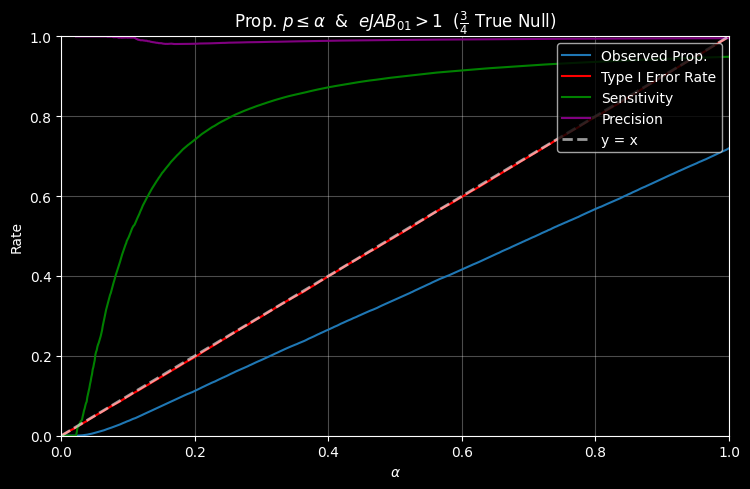

In [30]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

# ----------------------------
# Match R's RNG and inputs
# ----------------------------
rng = np.random.default_rng(277)

NSim   = int(7e4) # number of simulation runs
myES   = np.array([0, 0, 0, 1]) # effect sizes (Cohen's d)
mySize = np.array([10, 20, 30, 50, 60, 70, 100, 200])
mySD   = np.array([1, 2, 4, 10])

# ----------------------------
# Single-run function (R: typeIerr_t)
# Returns N, ES, SD, pVal, eJAB01
# ----------------------------
def typeIerr_t(N: int, ES: float, SD: float):
    # NOTE: This exactly mirrors the R line: rnorm(N, ES, 1) * SD
    # i.e., draw N ~ Normal(mean=ES, sd=1), then multiply by SD.
    # (So the resulting data have mean ES*SD and sd=SD.)
    data = rng.normal(loc=ES, scale=1.0, size=N) * SD

    # one-sample two-sided t-test against 0
    pVal = st.ttest_1samp(data, popmean=0.0, alternative="two-sided").pvalue

    # eJAB01 = sqrt(N) * exp(-0.5 * qchisq(1 - pVal, df=1) * (N-1)/N)
    # protect against pVal==0 or 1 in the chi-square quantile
    eps = 1e-12
    q = st.chi2.ppf(np.clip(1.0 - pVal, eps, 1.0 - eps), df=1)
    eJAB01 = np.sqrt(N) * np.exp(-0.5 * q * (N - 1.0) / N)

    return N, ES, SD, pVal, eJAB01

# ----------------------------
# Run NSim simulations (sample N, ES, SD each time, like R's sample(..., 1))
# ----------------------------
rows = []
for _ in range(NSim):
    N  = int(rng.choice(mySize))
    ES = float(rng.choice(myES))
    SD = float(rng.choice(mySD))
    rows.append(typeIerr_t(N, ES, SD))

df = pd.DataFrame(rows, columns=["N", "ES", "SD", "pVal", "eJAB01"])

# ----------------------------
# Sweep alpha thresholds and compute the four series
# ----------------------------
threshold = np.linspace(0.0, 1.0, 1000)

# True Type I (t-test): count of null runs (ES==0) with p <= alpha
grand_truth = np.array([
    np.sum((df["pVal"] <= x) & (df["ES"] == 0.0))
    for x in threshold
], dtype=float)

# Observed flagged proportion overall: p <= alpha AND eJAB01 > 1  (unconditioned)
count = np.array([
    np.sum((df["pVal"] <= x) & (df["eJAB01"] > 1.0))
    for x in threshold
], dtype=float)

# Diagnostic hits: among null (ES==0), flagged (p <= alpha AND eJAB01 > 1)
hit = np.array([
    np.sum((df["pVal"] <= x) & (df["eJAB01"] > 1.0) & (df["ES"] == 0.0))
    for x in threshold
], dtype=float)

# Denominators for rates
n_null = float(np.sum(df["ES"] == 0.0))  # number of H0 runs

# Guard against divide-by-zero where needed
with np.errstate(divide="ignore", invalid="ignore"):
    observed_prop = count / float(NSim)                         # blue
    type1_rate    = grand_truth / n_null                        # red
    sensitivity   = np.where(grand_truth > 0, hit / grand_truth, np.nan)  # green
    precision     = np.where(count > 0, hit / count, np.nan)               # purple

# ----------------------------
# Plot (styled to match your R figure)
# ----------------------------
plt.style.use("dark_background")
plt.figure(figsize=(7.6, 5.0))

plt.plot(threshold, observed_prop, color="#1f77b4", marker=None, label="Observed Prop.")
plt.plot(threshold, type1_rate,    color="red",    marker=None, label="Type I Error Rate")
plt.plot(threshold, sensitivity,   color="green",  marker=None, label="Sensitivity")
plt.plot(threshold, precision,     color="purple", marker=None, label="Precision")

# y = x reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="white", linewidth=2, alpha=0.6, label="y = x")

plt.title(r"Prop. $p \leq \alpha$  &  $eJAB_{01} > 1$  ($\frac{3}{4}$ True Null)")
plt.xlabel(r"$\alpha$")
plt.ylabel("Rate")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


## Rewrote to plot against $n$, refactored for python

- Numpy beats R at vectorization efficiency, we take advantage of this. 
- We run 100,000 simulations per 33 ns for 3 ds (d=1 results in sensitivity=1 for all n)

Computing d=0.3...


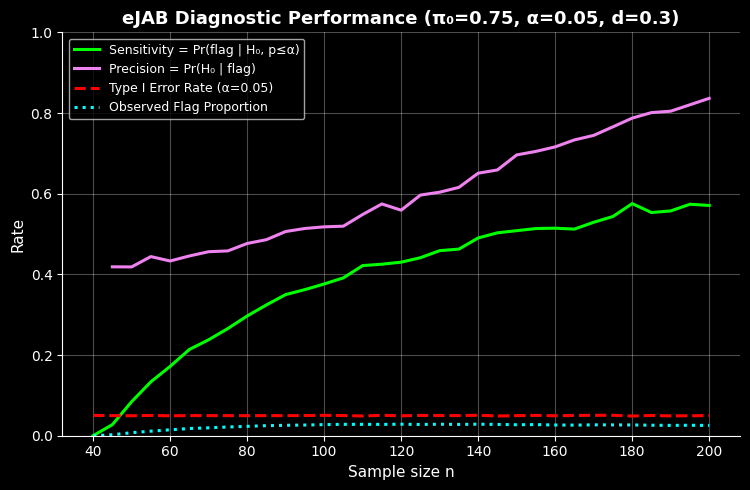

Computing d=0.5...


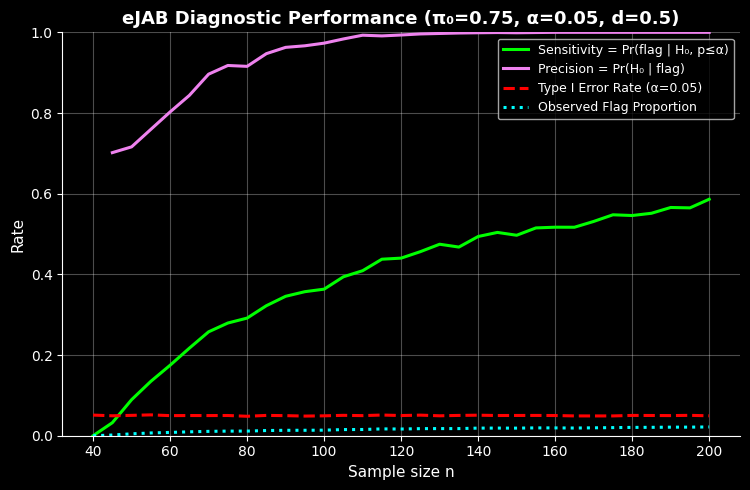

Computing d=1.0...


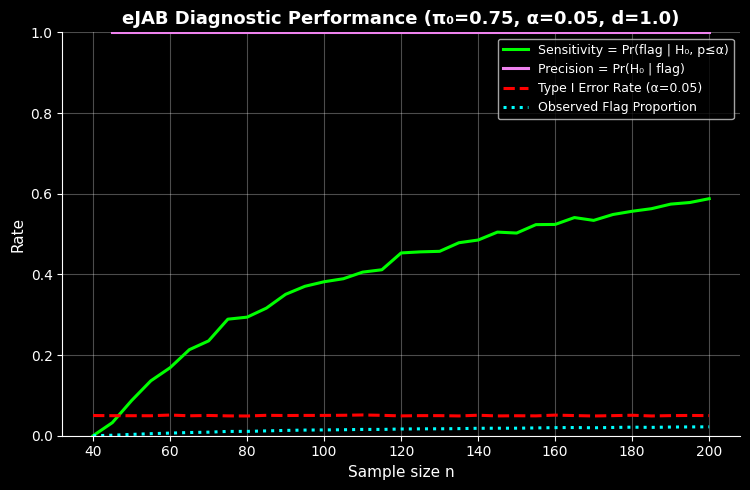

In [33]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Configuration
rng = np.random.default_rng(277)
ALPHA = 0.05
PI0 = 0.75
R_PER_N = 100_000
N_VALUES = np.arange(40, 205, 5)
EFFECT_SIZES = [0.3, 0.5, 1.0]


@dataclass
class DiagnosticMetrics:
    """Store diagnostic performance metrics."""
    sensitivity: np.ndarray
    precision: np.ndarray
    type1_rate: np.ndarray
    observed_proportion: np.ndarray


def ejab_statistic(n: int, p_values: np.ndarray) -> np.ndarray:
    """Calculate eJAB statistic for given sample size and p-values."""
    q = st.chi2.ppf(1.0 - p_values, df=1)
    return np.sqrt(n) * np.exp(-0.5 * q * (n - 1.0) / n)


def simulate_studies(n: int, num_sims: int, effect_size: float) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Simulate studies and return p-values, eJAB statistics, and null indicators."""
    is_null = rng.random(num_sims) < PI0
    true_effects = np.where(is_null, 0.0, effect_size)
    data = rng.normal(loc=true_effects[:, None], scale=1.0, size=(num_sims, n))
    p_values = st.ttest_1samp(data, 0.0, axis=1, alternative="two-sided").pvalue
    ejab_values = ejab_statistic(n, p_values)
    return p_values, ejab_values, is_null


def safe_divide(numerator: float, denominator: float) -> float:
    """Safely divide, returning NaN if denominator is zero."""
    return numerator / denominator if denominator > 0 else np.nan


def compute_metrics_for_n(n: int, effect_size: float) -> dict:
    """Compute all diagnostic metrics for a single sample size."""
    p_values, ejab_values, is_null = simulate_studies(n, R_PER_N, effect_size)
    
    # Define event indicators
    significant = p_values <= ALPHA
    flagged = significant & (ejab_values > 1.0)
    
    # Compute conditional counts
    null_significant = is_null & significant
    null_flagged = is_null & flagged
    
    # Aggregate counts
    n_null_sig = np.sum(null_significant)
    n_null_flag = np.sum(null_flagged)
    n_total_flag = np.sum(flagged)
    n_null = np.sum(is_null)
    
    return {
        'sensitivity': safe_divide(n_null_flag, n_null_sig),
        'precision': safe_divide(n_null_flag, n_total_flag),
        'type1_rate': safe_divide(n_null_sig, n_null),
        'observed_proportion': n_total_flag / R_PER_N
    }


def compute_all_metrics(n_values: np.ndarray, effect_size: float) -> DiagnosticMetrics:
    """Compute diagnostic metrics across all sample sizes."""
    results = [compute_metrics_for_n(n, effect_size) for n in n_values]
    
    return DiagnosticMetrics(
        sensitivity=np.array([r['sensitivity'] for r in results]),
        precision=np.array([r['precision'] for r in results]),
        type1_rate=np.array([r['type1_rate'] for r in results]),
        observed_proportion=np.array([r['observed_proportion'] for r in results])
    )


def plot_diagnostic_performance(n_values: np.ndarray, metrics: DiagnosticMetrics, effect_size: float):
    """Create diagnostic performance plot."""
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(7.6, 5.0))
    
    # Plot metrics
    plot_config = [
        (metrics.sensitivity, "lime", "-", "Sensitivity = Pr(flag | H₀, p≤α)"),
        (metrics.precision, "violet", "-", "Precision = Pr(H₀ | flag)"),
        (metrics.type1_rate, "red", "--", f"Type I Error Rate (α={ALPHA})"),
        (metrics.observed_proportion, "cyan", ":", "Observed Flag Proportion")
    ]
    
    for data, color, style, label in plot_config:
        ax.plot(n_values, data, color=color, linestyle=style, lw=2.2, label=label)
    
    # Style axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Sample size n", fontsize=11)
    ax.set_ylabel("Rate", fontsize=11)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"eJAB Diagnostic Performance (π₀={PI0}, α={ALPHA}, d={effect_size})",
                 fontsize=13, fontweight='bold')
    ax.legend(loc="best", fontsize=9)
    
    plt.tight_layout()
    plt.show()


# Run analysis for all effect sizes
for effect_size in EFFECT_SIZES:
    print(f"Computing d={effect_size}...")
    metrics = compute_all_metrics(N_VALUES, effect_size)
    plot_diagnostic_performance(N_VALUES, metrics, effect_size)

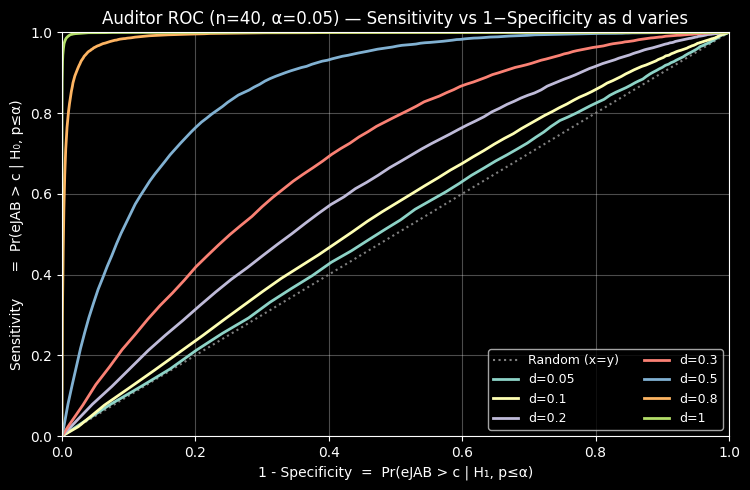

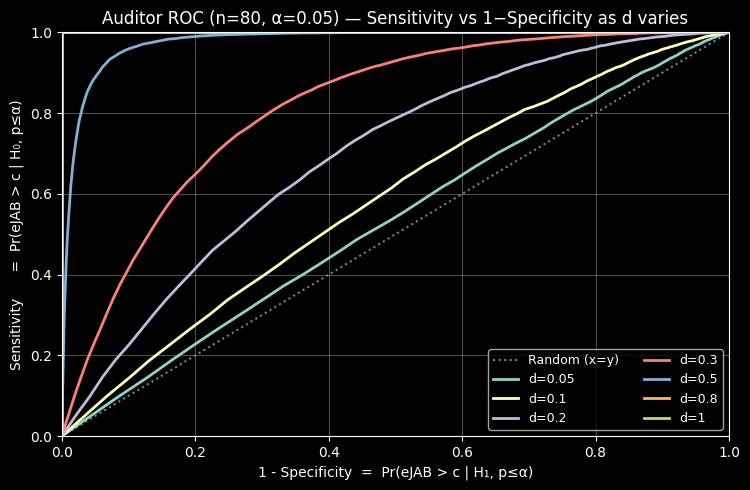

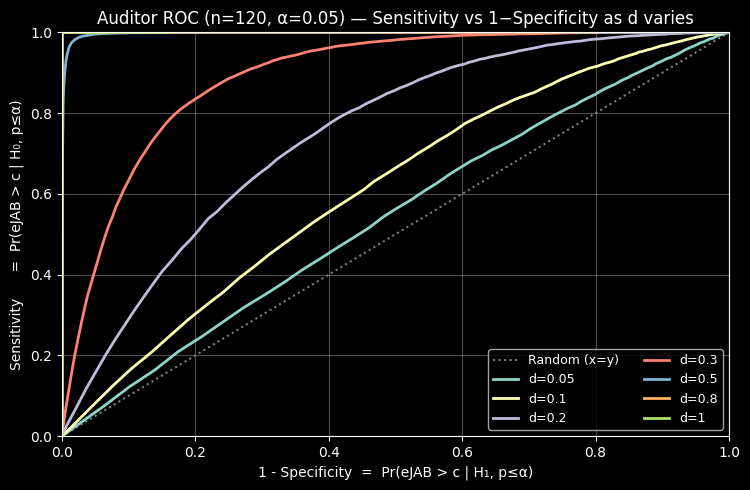

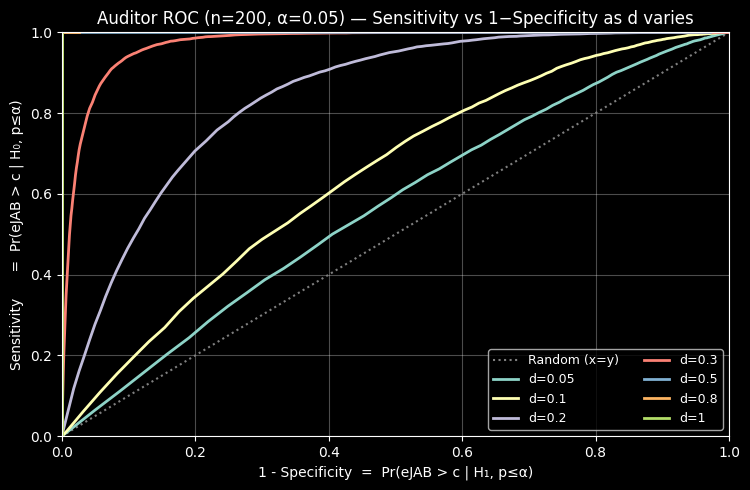

In [37]:
# =========================
# ROC: Sensitivity vs 1-Specificity as effect size varies
# (eJAB as an auditor of t-test positives)
# =========================

# Choose a few sample sizes to show (multiple figures)
N_LIST_FOR_ROC = [40, 80, 120, 200]

# Coarse-stepped effect sizes, starting small
D_LIST_FOR_ROC = [0.05, 0.10, 0.20, 0.30, 0.50, 0.80, 1.0]

C_GRID = np.r_[np.inf, np.geomspace(1e3, 1e-12, 800), 0.0]  # from huge to tiny + explicit 0

# Replicates for ROC (separate from R_PER_N if you want)
R_ROC = 200_000


def ejab_statistic_fast(n: int, p_values: np.ndarray) -> np.ndarray:
    q = st.chi2.ppf(1.0 - p_values, df=1)
    return np.sqrt(n) * np.exp(-0.5 * q * (n - 1.0) / n)

def simulate_under(n: int, R: int, effect_size: float) -> tuple[np.ndarray, np.ndarray]:
    """Simulate R experiments at sample size n under a single effect size (no mixing)."""
    X = rng.normal(loc=effect_size, scale=1.0, size=(R, n))
    p = st.ttest_1samp(X, 0.0, axis=1, alternative="two-sided").pvalue
    e = ejab_statistic_fast(n, p)
    return p, e

def auditor_roc_for(n: int, d: float, alpha: float, c_grid: np.ndarray, R: int):
    """
    Auditor ROC for fixed n and effect size d.
    x = 1 - specificity = Pr(eJAB>c | H1, p<=alpha)
    y = sensitivity     = Pr(eJAB>c | H0, p<=alpha)
    """
    p0, e0 = simulate_under(n, R, effect_size=0.0)
    p1, e1 = simulate_under(n, R, effect_size=d)

    sig0 = (p0 <= alpha)
    sig1 = (p1 <= alpha)

    if sig0.sum() == 0 or sig1.sum() == 0:
        return (np.full_like(c_grid, np.nan, float),
                np.full_like(c_grid, np.nan, float))

    # Vectorized computation over c_grid
    # For c = +inf: (e > c) is False -> 0; for c = 0: (e > 0) is True -> 1
    e0_sig = e0[sig0][:, None]  # shape (m0, 1)
    e1_sig = e1[sig1][:, None]  # shape (m1, 1)
    mask0  = (e0_sig > c_grid[None, :])        # flags under H0|sig
    mask1  = (e1_sig > c_grid[None, :])        # flags under H1|sig

    y_vals = mask0.mean(axis=0)                # TPR
    x_vals = mask1.mean(axis=0)                # FPR

    return x_vals, y_vals

# ---- Plot ROC per n ----
plt.style.use("dark_background")
for n in N_LIST_FOR_ROC:
    plt.figure(figsize=(7.6, 5.0))
    plt.plot([0, 1], [0, 1], ':', color='gray', lw=1.5, label='Random (x=y)')

    for d in D_LIST_FOR_ROC:
        x_fpr, y_tpr = auditor_roc_for(n, d, ALPHA, C_GRID, R_ROC)
        if np.all(np.isnan(x_fpr)) or np.all(np.isnan(y_tpr)):
            continue
        # ensure monotone x for plotting
        order = np.argsort(x_fpr)
        plt.plot(x_fpr[order], y_tpr[order], lw=2.0, label=f"d={d:g}")

    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel("1 - Specificity  =  Pr(eJAB > c | H₁, p≤α)")
    plt.ylabel("Sensitivity      =  Pr(eJAB > c | H₀, p≤α)")
    plt.title(f"Auditor ROC (n={n}, α={ALPHA}) — Sensitivity vs 1−Specificity as d varies")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="lower right", ncols=2, fontsize=9)
    plt.tight_layout()
    plt.show()